# Analysis for WM_NoiseV11 in Python instead of R because pandas > tidyverse
### HKular 11.7.23

# Import libraries and load data, some data wrangling

In [9]:
## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os

# Get the user's login name
login_name = os.getlogin()
# Set the working directory
directory_path = f'/Users/{login_name}/Documents/Github/noisefx/Starburst_V11'
os.chdir(directory_path)

# Load data
V11 = pd.read_csv('WM_noiseV11.csv') # good subjects
V11b = pd.read_csv('WM_noiseV11_bad.csv') # bad subjects to compare

# Make numerical values that are factors actually factors
factor_mapping = {
    'distractor': {1: 'none', 2: 'ignore', 3: 'attend'},
    'kappa': {100: 'high', 5000: 'low'},
    'change': {10: 'ccw', -10: 'cw'},
    'dist': {114: 'ccw', 112: 'ccw', 117: 'cw', 115: 'cw'}
}

V11.replace(factor_mapping, inplace=True)
V11b.replace(factor_mapping, inplace=True)


# Individual subject quality check

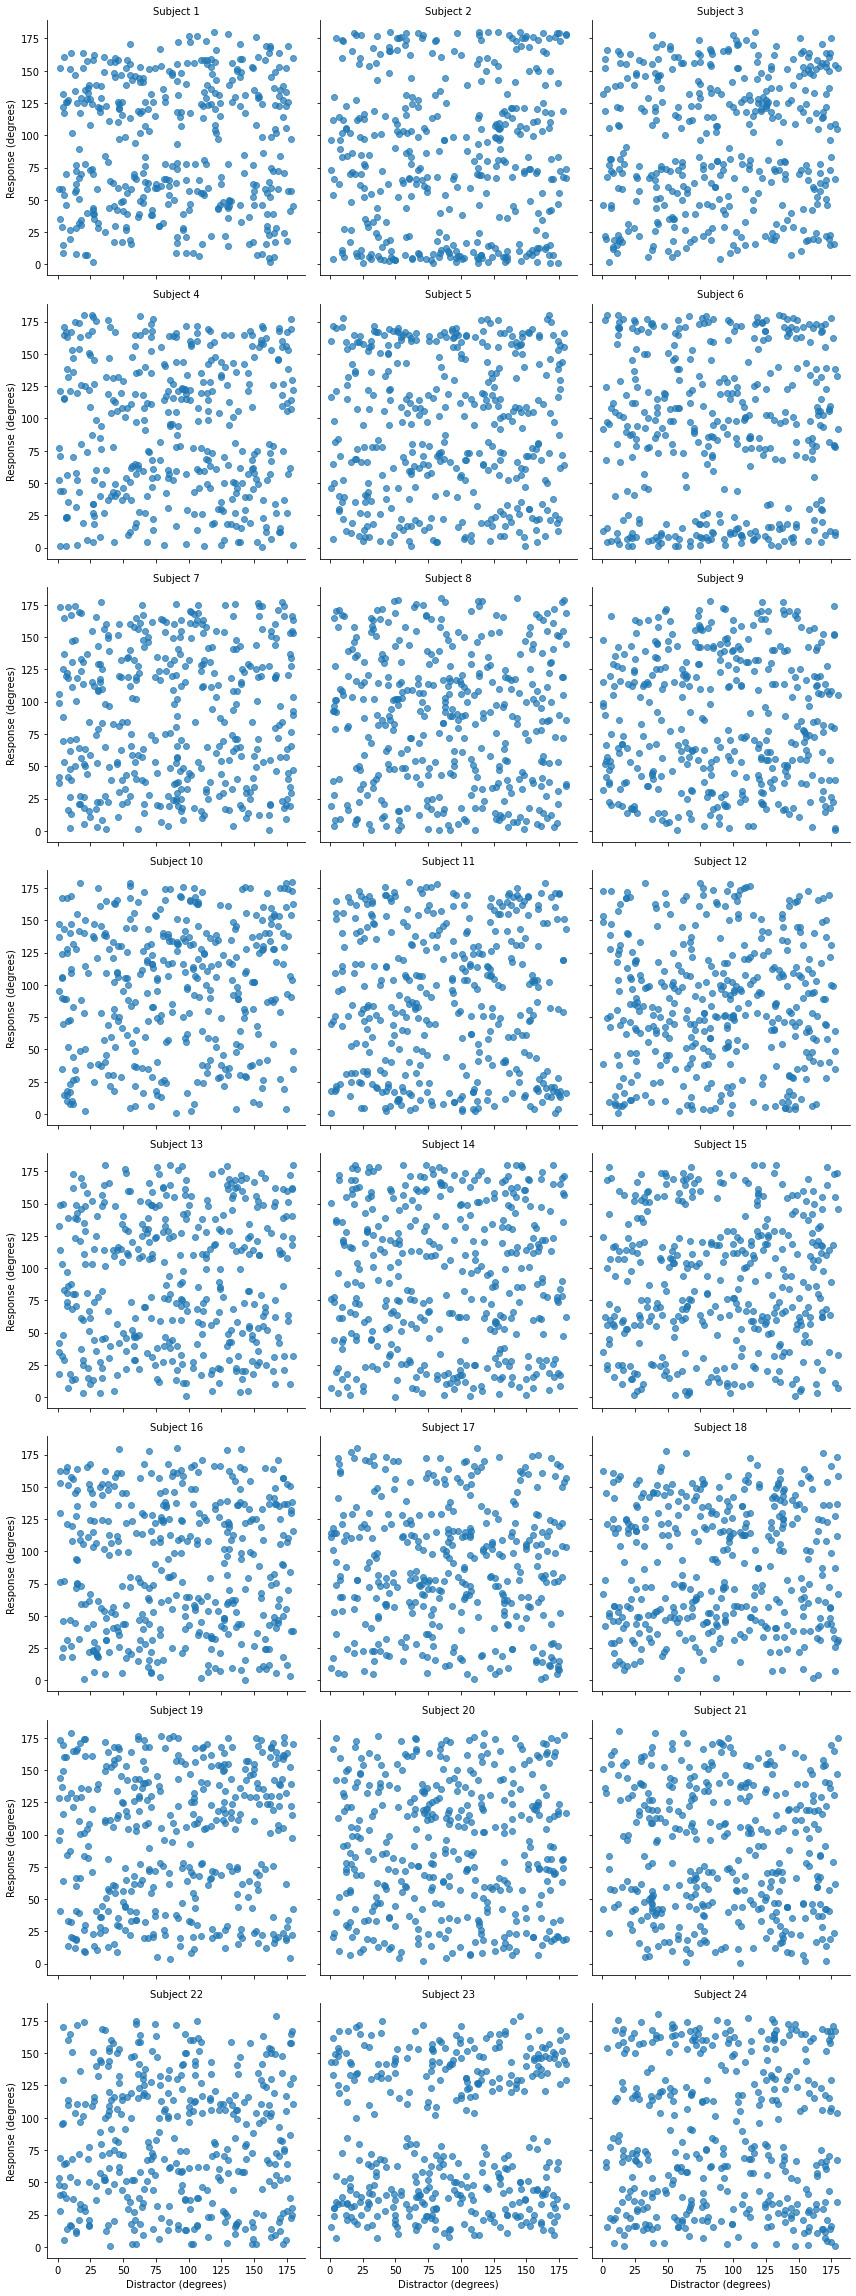

In [13]:
## If they withdraw from the experiment before completing all trials (n = 576)
ntrials = V11['subject'].value_counts()
# V11 = V11[~V11['subject'].isin(insert attrition here)]

# Responded to at least 90% of the distractors in the attend-distractor condition
attendrespcheck = V11[V11['distractor'] == 'attend'].groupby('subject')['dist'].count()
attendrespcheck = attendrespcheck[attendrespcheck.isna()]
for subject, count in attendrespcheck.items():
    if count > 0.1 * ntrials[subject] / 3:
        print(f"exclude subject {subject} no response to attend")
        
# Responded to more than 10% of the distractors in the ignore-distractor condition
ignorerespcheck = V11[V11['distractor'] == 'ignore'].groupby('subject')['dist'].count()
ignorerespcheck = ignorerespcheck[ignorerespcheck.isna()]
for subject, count in ignorerespcheck.items():
    if count < 0.9 * ntrials[subject] / 3:
        print(f"exclude subject {subject} response to ignore")

# Responded to at least 90% of the targets
nonrespcheck = V11.groupby('subject')['resp'].count()
nonrespcheck = nonrespcheck[nonrespcheck.isna()]
for subject, count in nonrespcheck.items():
    if count > 0.1 * ntrials[subject]:
        print(f"exclude subject {subject} no response to target")

# Subjects will be removed if there is evidence for responses clustered around the orientation of the distractor
# Instead of around the memory target, a cluster of responses around the distractor orientation suggests non-compliance with task instructions.
taskcheck = V11.dropna(subset=['distractorori', 'resp'])
# Create scatter plot (You might need to customize this part)
g = sns.FacetGrid(V11, col="subject", col_wrap=3, height=4)
g.map(plt.scatter, "distractorori", "resp", alpha=.7)
g.set_axis_labels("Distractor (degrees)", "Response (degrees)")
g.set_titles(col_template="Subject {col_name}")
plt.show()

# The average measured performance error is greater than 49 degrees
from scipy.stats import circmean
from scipy.stats import circstd
perfcheck = V11.groupby('subject').agg(
    circ_mean=('acc', lambda x: circmean(x * np.pi / 180)),
    circ_std=('acc', lambda x: circstd(x * np.pi / 180))
)
perfcheck = perfcheck[perfcheck['circ_std'] * 180 / np.pi > 49]
for subject in perfcheck.index:
    print(f"exclude subject {subject} large behavior error")
       

In [20]:
# check RTs
from scipy.stats import ttest_ind

# Check RTs for target
targRT = V11.dropna(subset=['resp']).groupby('subject')['targRT'].agg(['mean', 'std']).reset_index()
targRTavg = targRT['mean'].mean()
targRTb = V11b.dropna(subset=['resp']).groupby('subject')['targRT'].agg(['mean', 'std']).reset_index()
targRTavgb = targRTb['mean'].mean()

# Check RTs for distractor response
distRT = V11.dropna(subset=['resp']).groupby('subject')['distRT'].agg(['mean', 'std']).reset_index()
distRTavg = distRT['mean'].mean()
distRTb = V11b.dropna(subset=['resp']).groupby('subject')['distRT'].agg(['mean', 'std']).reset_index()
distRTavgb = distRTb['mean'].mean()

# Compare with two-sample t-test
distRTtest_results = ttest_ind(distRT['mean'], distRTavgb, equal_var=False)
targRTtest_results = ttest_ind(targRT['mean'], targRTavgb, equal_var=False)

# Look at when misses were, early? later blocks? middle blocks?
# Filter (attend trials) plot block and counts
V11b['trial'] = V11b.groupby('subject').cumcount() + 1
V11b['block'] = np.tile(np.repeat(np.arange(1, 25), 24), len(V11b) // 24)

nan_count = V11b[V11b['distractorname'] == 'attend'].groupby('block')['distRT'].apply(lambda x: sum(x.isna())).reset_index()

sns.lineplot(x='block', y='distRT', data=nan_count)
plt.xlabel("Block Number")
plt.ylabel("NaN Count")
plt.title("No response to attend")
plt.show()

# Look at when good subs miss attend response
V11['block'] = np.tile(np.repeat(np.arange(1, 25), 24), len(V11) // 24)

nan_count_g = V11[V11['distractorname'] == 'attend'].groupby('block')['distRT'].apply(lambda x: sum(x.isna())).reset_index()

sns.lineplot(x='block', y='distRT', data=nan_count_g)
plt.xlabel("Block Number")
plt.ylabel("NaN Count")
plt.title("No response to attend")
plt.show()

# Look at accuracy on distractor
dist_accb = V11b[V11b['distractorname'] != 'none'].dropna(subset=['distRT']).groupby('subject').agg(
    count=pd.NamedAgg(column='dist', aggfunc=lambda x: sum(x == V11b['change'])),
    total=pd.NamedAgg(column='change', aggfunc=lambda x: len(x))
)

dist_acc = V11[V11['distractorname'] != 'none'].dropna(subset=['distRT']).groupby('subject').agg(
    count=pd.NamedAgg(column='dist', aggfunc=lambda x: sum(x == V11['change'])),
    total=pd.NamedAgg(column='change', aggfunc=lambda x: len(x))
)

# Plot distractor accuracy against chance
data = pd.concat([dist_acc.assign(group='Good'), dist_accb.assign(group='Bad')])
sns.boxplot(x='group', y='count', data=data / data['total'])
plt.axhline(0.5, linestyle='--', color='purple')
plt.text(1.5, 0.5, 'chance', va='center', ha='left', color='purple')
plt.xlabel("Subjects")
plt.ylabel("Accuracy")
plt.title("Distractor response accuracy")
plt.show()

/Users/hollykular/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  1.25
/Users/hollykular/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  rcount = um.maximum(rcount - ddof, 0)


ValueError: Length of values (138240) does not match length of index (5760)